# web search

In [40]:
from autogen_core.tools import FunctionTool
from ddgs import DDGS
import requests
from markdownify import markdownify as html_to_md
from autogen_core import CancellationToken

import re

def clean_text(text: str) -> str:
    if not text:
        return text
    text = text.replace("\t", " ")
    text = re.sub(r"\n{3,}", "\n\n", text)
    text = re.sub(r" {2,}", " ", text)
    text = "\n".join(line.strip() for line in text.splitlines())
    return text.strip()

class DuckDuckGoAPI:
    """Backend wrapper around DuckDuckGo search + page fetching."""

    def __init__(self):
        self.ddg = DDGS()

    def search(self, query: str, page: int = 1, max_results: int = 10):
        """
        DuckDuckGo search
        """

        # DuckDuckGo Search API (text search)
        results = list(
            self.ddg.text(
                query=query,
                region="wt-wt",
                safesearch="moderate",
                timelimit="y",
                max_results=max_results,
                page=page,
            )
        )

        # Normalize result structure
        normalized = []
        for i, r in enumerate(results):
            normalized.append({
                "id": i,
                "title": r.get("title"),
                "url": r.get("href"),
                "snippet": r.get("body"),
            })

        return normalized

    def fetch(self, url: str):
        """
        Fetch a webpage and return Markdown.
        """
        try:
            response = requests.get(url, timeout=10)
            response.raise_for_status()

            html = response.text

            # Convert HTML → Markdown
            markdown = html_to_md(html)

            cleaned = clean_text(markdown)
            return cleaned[:20000]

        except Exception as e:
            return f"Error fetching page: {e}"


# ----------------------------------------------------------------------
# Autogen-Compatible Search Tool Wrapper
# ----------------------------------------------------------------------
class WebSearchTool:
    def __init__(self, search_api):
        self.api = search_api
        self.current_query = None
        self.current_page = 1
        self.current_results = []

        self.search_tool = FunctionTool(self.search, name="search_web", description=self.search.__doc__)
        self.select_tool = FunctionTool(self.select_webpage, name="open_webpage", description=self.select_webpage.__doc__)
        self.next_page_tool = FunctionTool(self.next_page, name="next_search_page", description=self.next_page.__doc__)

    # ------------------- TOOLS -------------------

    async def search(self, query: str, page: int = 1):
        """Perform Web Search using DuckDuckGo."""
        self.current_query = query
        self.current_page = page
        self.current_results = self.api.search(query, page)

        return {
            "query": query,
            "page": page,
            "results": self.current_results
        }

    async def select_webpage(self, result_id: int):
        """Fetch selected webpage content."""
        if not self.current_results:
            return {"error": "No active search results"}

        if result_id < 0 or result_id >= len(self.current_results):
            return {"error": "Invalid result_id"}

        url = self.current_results[result_id]["url"]
        content = self.api.fetch(url)

        return {
            "url": url,
            "content": content
        }

    async def next_page(self):
        """Load the next page of DuckDuckGo search results."""
        if not self.current_query:
            return {"error": "No active query"}

        self.current_page += 1
        self.current_results = self.api.search(self.current_query, self.current_page)

        return {
            "query": self.current_query,
            "page": self.current_page,
            "results": self.current_results
        }

    def get_tools(self):
        return [
            self.search_tool,
            self.select_tool,
            self.next_page_tool
        ]


In [41]:
duck_api = DuckDuckGoAPI()
web_tools = WebSearchTool(duck_api)

In [42]:
await web_tools.search_tool.run_json({"query": "Diffusion LLM", "page":1}, CancellationToken())

{'query': 'Diffusion LLM',
 'page': 1,
 'results': [{'id': 0,
   'title': '[2502.09992] Large Language Diffusion Models - arXiv.org',
   'url': 'https://arxiv.org/abs/2502.09992',
   'snippet': 'A diffusion model trained from scratch that models distributions through a forward and reverse process, parameterized by a Transformer. It outperforms autoregressive models on various benchmarks and shows strong in-context learning and instruction-following abilities.'},
  {'id': 1,
   'title': 'Inception Labs banks $50M to make diffusion LLMs 10x faster',
   'url': 'https://techfundingnews.com/inception-labs-banks-50m-to-make-diffusion-llms-10x-faster/',
   'snippet': "Inception's flagship model, Mercury, is the world's first commercially available diffusion LLM . It outpaces even speed-optimised models from OpenAI, Anthropic, and Google by 5-10x, while matching their precision. Mercury comes in two versions: a general-purpose model for conversational tasks and Mercury Coder, tuned for code ge

In [46]:
results = await web_tools.select_tool.run_json({"result_id": 1}, CancellationToken())

Inception Labs banks $50M to make diffusion LLMs 10x faster — TFN

[![Tech Funding News](https://techfundingnews.com/wp-content/uploads/2021/07/cropped-android-chrome-192x192-1.png)](https://techfundingnews.com/)
[![Tech Funding News](https://techfundingnews.com/wp-content/uploads/2021/07/cropped-android-chrome-192x192-1.png)](https://techfundingnews.com/)

* [UK](https://techfundingnews.com/category/uk/)
* [Europe](https://techfundingnews.com/category/europe/)
* [US](https://techfundingnews.com/category/us/)
* [VC News](https://techfundingnews.com/category/vc/)
* [Interviews](https://techfundingnews.com/category/interviews/)
* [Partner Content](https://techfundingnews.com/category/sponsored/)
* [AI News](https://techfundingnews.com/category/AI/)

#### Subscribe TFN for Daily News Alerts

Email address:

By clicking submit, you agree to share your email address with TFN to receive marketing, updates, and other emails from the site owner. Use the unsubscribe link in the emails to opt ou
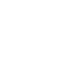
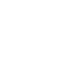
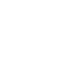
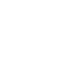
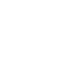
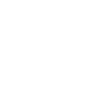
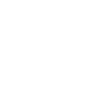
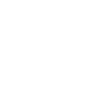
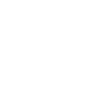
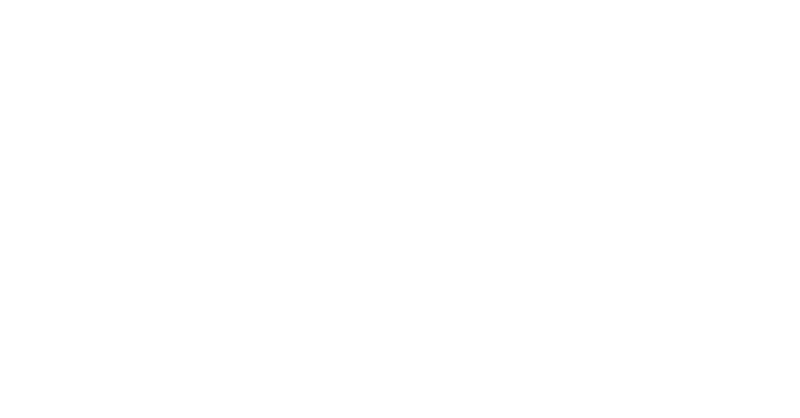

In [47]:
print(results["content"])

In [48]:
await web_tools.next_page_tool.run_json({}, CancellationToken())

{'query': 'Diffusion LLM',
 'page': 2,
 'results': [{'id': 0,
   'title': 'arXiv [2506.17298] Mercury: Ultra-Fast Language Models Based on Diffusion',
   'url': 'https://arxiv.org/abs/2506.17298',
   'snippet': 'June 17, 2025 - View a PDF of the paper titled Mercury: Ultra-Fast Language Models Based on Diffusion , by Inception Labs and 12 other authors View PDF HTML (experimental) Abstract:We present Mercury, a new generation of commercial-scale large language models (LLMs) based on diffusion .'},
  {'id': 1,
   'title': 'Simon Willison Gemini Diffusion',
   'url': 'https://simonwillison.net/2025/May/21/gemini-diffusion/',
   'snippet': "May 21, 2025 - Another of the announcements from Google I/O yesterday was Gemini Diffusion , Google's first LLM to use diffusion (similar to image models like Imagen and Stable Diffusion ) in place of transformers. …"},
  {'id': 2,
   'title': 'IBM Diffusion models challenge GPT as next-generation AI emerges | IBM',
   'url': 'https://www.ibm.com/think

# Arxiv tool

In [61]:
from autogen_core.tools import FunctionTool
import requests
import xml.etree.ElementTree as ET
from markdownify import markdownify as html_to_md
from pypdf import PdfReader
import re
import io


# ------------------------------------------------------------
# Text Normalization Helper
# ------------------------------------------------------------
def clean_text(text: str) -> str:
    """
    Clean and normalize extracted text.

    Operations performed:
    - Remove tab characters.
    - Collapse 3 or more consecutive newlines into exactly 2.
    - Collapse multiple consecutive spaces into one.
    - Strip leading/trailing whitespace from each line.
    - Strip whitespace at the document edges.

    Parameters
    ----------
    text : str
        Raw text extracted from PDF or HTML.

    Returns
    -------
    str
        Cleaned, compact, readable text.
    """
    if not text:
        return text

    text = text.replace("\t", " ")
    text = re.sub(r"\n{3,}", "\n\n", text)
    text = re.sub(r" {2,}", " ", text)
    text = "\n".join(line.strip() for line in text.splitlines())

    return text.strip()


# ------------------------------------------------------------
# PDF Content Reader — Provides Scrolling Windows
# ------------------------------------------------------------
class ArxivPaperReader:
    """
    Extracts text from a PDF and provides scrollable "windows" of content.

    This allows an LLM agent to read a paper chunk-by-chunk, simulating
    a scrolling browser window.

    Attributes
    ----------
    window_size : int
        Number of characters per window.
    windows : list[str]
        The split windows of text.
    position : int
        Current window index.
    """

    def __init__(self, window_size_chars=3000):
        """
        Initialize the reader.

        Parameters
        ----------
        window_size_chars : int, optional
            Maximum size of each scrolling window, by default 3000.
        """
        self.window_size = window_size_chars
        self.windows = []
        self.position = 0

    def load_pdf(self, pdf_url: str) -> int:
        """
        Download and parse a PDF from a URL, extract text, clean it,
        and split into windows.

        Parameters
        ----------
        pdf_url : str
            Direct URL to the PDF.

        Returns
        -------
        int
            Number of windows created.
        """
        response = requests.get(pdf_url, timeout=15)
        response.raise_for_status()

        reader = PdfReader(io.BytesIO(response.content))
        full_text = ""

        for page in reader.pages:
            extracted = page.extract_text() or ""
            full_text += extracted + "\n\n"

        full_text = clean_text(full_text)

        self.windows = [
            full_text[i:i + self.window_size]
            for i in range(0, len(full_text), self.window_size)
        ]
        self.position = 0

        return len(self.windows)

    def get_window(self, index: int) -> str:
        """
        Return a specific window of text.

        Parameters
        ----------
        index : int
            Window index.

        Returns
        -------
        str or dict
            Text of the window, or error dict if out of range.
        """
        if index < 0 or index >= len(self.windows):
            return {"error": "Window index out of range"}
        return self.windows[index]

    def next_window(self) -> str:
        """
        Move to the next window.

        Returns
        -------
        str or dict
            Next window text or error dict.
        """
        if self.position + 1 >= len(self.windows):
            return {"error": "Already at last window"}
        self.position += 1
        return self.get_window(self.position)

    def prev_window(self) -> str:
        """
        Move to the previous window.

        Returns
        -------
        str or dict
            Previous window text or error dict.
        """
        if self.position - 1 < 0:
            return {"error": "Already at first window"}
        self.position -= 1
        return self.get_window(self.position)


# ------------------------------------------------------------
# ArXiv API Wrapper
# ------------------------------------------------------------
class ArxivAPI:
    """
    A minimal wrapper around the ArXiv API, supporting searching
    and extracting metadata needed to locate PDFs.

    Methods
    -------
    search(query, page, max_results)
        Perform a paginated ArXiv search.
    """

    ARXIV_URL = "http://export.arxiv.org/api/query"

    def search(self, query: str, page: int = 1, max_results: int = 10):
        """
        Perform an ArXiv search using the official API.

        Parameters
        ----------
        query : str
            Search query (e.g., "machine learning", "cat:cs.CL").
        page : int, optional
            Page number (converted into API 'start' parameter).
        max_results : int, optional
            Number of items per page.

        Returns
        -------
        list[dict]
            List of paper metadata dictionaries, each containing:
            - id
            - title
            - authors
            - summary
            - pdf_url
        """
        start = (page - 1) * max_results

        params = {"search_query": query, "start": start, "max_results": max_results}
        response = requests.get(self.ARXIV_URL, params=params, timeout=10)
        response.raise_for_status()

        root = ET.fromstring(response.text)
        ns = {"atom": "http://www.w3.org/2005/Atom"}

        results = []

        for i, entry in enumerate(root.findall("atom:entry", ns)):
            title = entry.find("atom:title", ns).text.strip()
            summary = entry.find("atom:summary", ns).text.strip()
            authors = [a.find("atom:name", ns).text.strip()
                       for a in entry.findall("atom:author", ns)]

            # Extract PDF link
            pdf_url = None
            for link in entry.findall("atom:link", ns):
                if link.attrib.get("title") == "pdf":
                    pdf_url = link.attrib["href"]

            if not pdf_url:
                id_url = entry.find("atom:id", ns).text
                pdf_url = id_url.replace("abs", "pdf")

            results.append({
                "id": i,
                "title": title,
                "authors": authors,
                "summary": summary,
                "pdf_url": pdf_url,
            })

        return results


# ------------------------------------------------------------
# Autogen-Compatible Tool Wrapper
# ------------------------------------------------------------
class ArxivSearchTool:
    """
    Provides an Autogen FunctionTool interface for:
    - ArXiv search
    - Opening a paper
    - Scrolling through PDF content in windows
    - Changing pages of search results

    This class is designed to be plugged directly into an Autogen agent.
    """

    def __init__(self, api: ArxivAPI, window_size_chars: int = 3000):
        """
        Initialize the tool.

        Parameters
        ----------
        api : ArxivAPI
            Backend API used for searching.
        window_size_chars : int, optional
            Size of PDF text windows for scrolling.
        """
        self.api = api
        self.current_query = None
        self.current_page = 1
        self.current_results = []

        # Reader for opened PDFs
        self.reader = ArxivPaperReader(window_size_chars)

        # Tools exposed to Autogen
        self.search_tool = FunctionTool(self.search, name="search_arxiv", description=self.search.__doc__)
        self.select_tool = FunctionTool(self.open_paper, name="open_paper", description=self.open_paper.__doc__)
        self.next_win_tool = FunctionTool(self.next_window, name="next_window", description=self.next_window.__doc__)
        self.prev_win_tool = FunctionTool(self.prev_window, name="prev_window", description=self.prev_window.__doc__)
        self.go_win_tool = FunctionTool(self.get_window, name="read_window", description=self.get_window.__doc__)
        self.next_page_tool = FunctionTool(self.next_page, name="next_arxiv_page", description=self.next_page.__doc__)

    # ------------------- SEARCH -------------------

    def search(self, query: str, page: int = 1):
        """
        Search ArXiv and store results.

        Parameters
        ----------
        query : str
            Search keyword or category.
        page : int, optional
            Page number to fetch.

        Returns
        -------
        dict
            Search metadata including results list.
        """
        self.current_query = query
        self.current_page = page
        self.current_results = self.api.search(query, page)

        return {
            "query": query,
            "page": page,
            "results": self.current_results
        }

    # ------------------- OPEN PAPER + LOAD PDF -------------------

    def open_paper(self, result_id: int):
        """
        Open a paper by ID from the current search results,
        download the PDF, extract text, and create windows.

        Parameters
        ----------
        result_id : int
            Index of the paper in current results.

        Returns
        -------
        dict
            Paper metadata and first window of content.
        """
        if not self.current_results:
            return {"error": "No active search results."}

        if result_id < 0 or result_id >= len(self.current_results):
            return {"error": "Invalid result_id."}

        paper = self.current_results[result_id]
        pdf_url = paper["pdf_url"]

        num_windows = self.reader.load_pdf(pdf_url)

        return {
            "title": paper["title"],
            "authors": paper["authors"],
            "total_windows": num_windows,
            "first_window": self.reader.get_window(0)
        }

    # ------------------- WINDOW CONTROLS -------------------

    def next_window(self):
        """
        Move forward one window in the opened paper.

        Returns
        -------
        str or dict
            Window text or error dictionary.
        """
        return self.reader.next_window()

    def prev_window(self):
        """
        Move backward one window in the opened paper.

        Returns
        -------
        str or dict
            Window text or error dictionary.
        """
        return self.reader.prev_window()

    def get_window(self, index: int):
        """
        Jump to a specific window.

        Parameters
        ----------
        index : int
            Window index.

        Returns
        -------
        str or dict
            Window text or error dictionary.
        """
        return self.reader.get_window(index)

    # ------------------- SEARCH PAGE NAVIGATION -------------------

    def next_page(self):
        """
        Fetch the next page of search results for the current query.

        Returns
        -------
        dict
            New search results.
        """
        if not self.current_query:
            return {"error": "No active query"}

        self.current_page += 1
        self.current_results = self.api.search(self.current_query, self.current_page)

        return {
            "query": self.current_query,
            "page": self.current_page,
            "results": self.current_results
        }


In [62]:
api = ArxivAPI()
arxiv_tools = ArxivSearchTool(api)

In [63]:
await arxiv_tools.search_tool.run_json({"query": "diffusion llm", "page":1}, CancellationToken())

{'query': 'diffusion llm',
 'page': 1,
 'results': [{'id': 0,
   'title': 'DINGO: Constrained Inference for Diffusion LLMs',
   'authors': ['Tarun Suresh',
    'Debangshu Banerjee',
    'Shubham Ugare',
    'Sasa Misailovic',
    'Gagandeep Singh'],
   'summary': "Diffusion LLMs have emerged as a promising alternative to conventional autoregressive LLMs, offering significant potential for improved runtime efficiency. However, existing diffusion models lack the ability to provably enforce user-specified formal constraints, such as regular expressions, which makes them unreliable for tasks that require structured outputs, such as fixed-schema JSON generation. Unlike autoregressive models that generate tokens sequentially, diffusion LLMs predict a block of tokens in parallel. This parallelism makes traditional constrained decoding algorithms, which are designed for sequential token prediction, ineffective at preserving the true output distribution. To address this limitation, we propose D

In [64]:
await arxiv_tools.select_tool.run_json({"result_id": 1}, CancellationToken())

/usr/local/lib/python3.11/site-packages/pypdf/_utils.py:262: ResourceWarning: unclosed <ssl.SSLSocket fd=71, family=2, type=1, proto=6, laddr=('172.18.0.2', 34364), raddr=('20.43.161.105', 443)>
  m = regex.search(name + tok)


{'title': 'Diffusion in LanCoIn3n+2 phases studied by perturbed angular correlation',
 'authors': ['Randal Newhouse', 'Gary S. Collins'],
 'total_windows': 6,
 'first_window': 'Diffusion in LanCoIn3n+2 phases studied by perturbed angular correlation\nRandal Newhouse a and Gary S. Collins b\nDepartment of Physics and Astronomy, Washington State University, Pullman, WA, USA\narandynewhouse@gmail.com, bcollins@wsu.edu\nKeywords: diffusion, perturbed angular correlation, PAC, hyperfine interaction, nuclear quadrupole\ninteraction, atomic jump frequency, intermetallic compound.\n\nAbstract. Jump frequencies of 111In/Cd tracer atoms were measured for a series of layered phases\nLanCoIn3n+2 using the technique of perturbed angular correlation of gamma rays (PAC). The\nfrequencies were determined by analysis of nucl ear quadrupole relaxation produced by fluctuating\nelectric field gradients. Samples were synthesized having nominal values n= 1, 2, 3, 5 and ∞, with\nn=∞ corresponding to the L1 2

# defence tech

In [95]:
import asyncio
from autogen_core.tools import FunctionTool
from markdownify import markdownify
import re
from playwright.sync_api import sync_playwright


def clean_markdown(text: str) -> str:
    """Normalize markdown whitespace."""
    text = re.sub(r"[ \t]+", " ", text)
    text = re.sub(r"\n{3,}", "\n\n", text)
    return text.strip()


# ----------------------------------------------------------------------
# Playwright-backed TechCrunch search API
# ----------------------------------------------------------------------
class TechCrunchSearchAPI:
    """
    Uses Playwright to load the TechCrunch site with JavaScript enabled
    so that dynamic search results can be scraped.
    """

    BASE_URL = "https://techcrunch.com/?s="

    def __init__(self, headless: bool = True):
        self.headless = headless

    def _load_page(self, url: str):
        """Load a page using Playwright and return page object."""
        pw = sync_playwright().start()
        browser = pw.chromium.launch(headless=self.headless)
        context = browser.new_context()
        page = context.new_page()
        page.goto(url, wait_until="networkidle")
        return pw, browser, context, page

    def search(self, query: str, page_number: int = 1):
        """
        Perform a TechCrunch search using Playwright-rendered DOM scraping.

        TechCrunch does pagination using:
        https://techcrunch.com/page/<n>/?s=query
        """

        if page_number == 1:
            url = f"{self.BASE_URL}{query}"
        else:
            url = f"https://techcrunch.com/page/{page_number}/?s={query}"

        pw, browser, context, page = self._load_page(url)

        # Select rendered article cards
        articles = page.locator("div.post-block")

        results = []
        count = articles.count()

        for i in range(count):
            card = articles.nth(i)
            title = card.locator("h2 a").inner_text()
            link = card.locator("h2 a").get_attribute("href")
            snippet = card.locator("div.post-block__content").inner_text()
            date = card.locator("time").get_attribute("datetime")

            results.append({
                "title": title.strip(),
                "url": link.strip(),
                "snippet": snippet.strip(),
                "date": date,
            })

        browser.close()
        pw.stop()

        return results

    def fetch_article(self, url: str) -> str:
        """Fetch full TC article and return Markdown."""
        pw, browser, context, page = self._load_page(url)
        html = page.content()
        browser.close()
        pw.stop()

        md = markdownify(html)
        return clean_markdown(md)


# ----------------------------------------------------------------------
# Autogen Tool Wrapper
# ----------------------------------------------------------------------
class TechCrunchSearchTool:
    """
    Autogen FunctionTool wrapper exposing:
    - search_tc(query, page)
    - open_tc_result(index)
    - next_tc_page()
    """

    def __init__(self, api: TechCrunchSearchAPI):
        self.api = api
        self.current_query = None
        self.current_page = 1
        self.current_results = []

        self.search_tool = FunctionTool(self.search, name="search_tc", description=self.search.__doc__)
        self.open_tool = FunctionTool(self.open, name="open_tc_result", description=self.open.__doc__)
        self.next_page_tool = FunctionTool(self.next_page, name="next_tc_page", description=self.next_page.__doc__)

    def search(self, query: str, page: int = 1):
        """
        Search TechCrunch on query.
        """
        self.current_query = query
        self.current_page = page
        self.current_results = self.api.search(query, page)
        return {
            "query": query,
            "page": page,
            "results": self.current_results,
        }

    def open(self, index: int):
        """
        Open techcruch article based on selected result index
        """
        if index < 0 or index >= len(self.current_results):
            return {"error": "Result index out of range."}

        res = self.current_results[index]
        md = self.api.fetch_article(res["url"])

        return {
            "title": res["title"],
            "url": res["url"],
            "content_markdown": md,
        }

    def next_page(self):
        """
        Go to next page of current query.
        """
        if not self.current_query:
            return {"error": "No active query to paginate."}

        self.current_page += 1
        self.current_results = self.api.search(self.current_query, self.current_page)

        return {
            "query": self.current_query,
            "page": self.current_page,
            "results": self.current_results,
        }


ModuleNotFoundError: No module named 'playwright'

In [92]:
api = TechCrunchSearchAPI(headless=True)
techcrunch_tools = TechCrunchSearchTool(api)

In [94]:
await techcrunch_tools.search_tool.run_json({"query": "drones","page":1}, CancellationToken())

<Response [200]>


{'query': 'drones', 'page': 1, 'results': []}